# Classifier Comparison

In this example we show how all **Concrete-ML** classifiers can be used in a manner that is very 
similar to scikit-learn classifiers. FHE classifiers have an API that builds upon the scikit-learn 
API, adding two new elements:

* compiling the model to FHE
* predicting in FHE

The FHE classifiers, which quantize the inputs and model parameters, can be tested in a simulated
FHE environment called the "Virtual Library". This type of execution is much faster than running in
FHE, but it does not operate over encrypted data. However, the Virtual Library is very useful to 
design and train FHE compatible classifiers, as it allows the user to investigate whether the FHE
constraints are met at design time.

### FHE runtime considerations and simulation

In this demo the test data is classified in FHE and the decision function values for the domain
grid are computed using simulation, using the Virtual Library. Thus:

* the accuracy reported is computed in FHE
* the red/blue decision function contours are computed with simulation

However, since the runtimes in FHE are high (it can take up to an hour to run test set 
classification in FHE), you have the option to run everything in simulation by 
setting ALWAYS_USE_VL=True.

In [6]:
# Source:
#   https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# Modified to integrate Concrete-ML functions by Zama
# License: BSD 3 clause

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import time
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from concrete.numpy.compilation.configuration import Configuration
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier

from concrete.ml.sklearn import DecisionTreeClassifier as ConcreteDecisionTreeClassifier
from concrete.ml.sklearn import LinearSVC as ConcreteLinearSVC
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression
from concrete.ml.sklearn import NeuralNetClassifier as ConcreteNeuralNetClassifier
from concrete.ml.sklearn import RandomForestClassifier as ConcreteRandomForestClassifier
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

%matplotlib inline

concrete_classifiers = [
    ConcreteDecisionTreeClassifier,
    ConcreteLinearSVC,
    ConcreteLogisticRegression,
    ConcreteNeuralNetClassifier,
]

ALWAYS_USE_VL = False

# We predict in FHE on the datasets and using the Virtual Library on the domain grid
# Note that the Virtual Library executes an integer model on data in the clear
# Nothing is encrypted when running in the Virtual Library
COMPIL_CONFIG_VL = Configuration(
    dump_artifacts_on_unexpected_failures=False,
    enable_unsafe_features=True,  # This is for our tests in Virtual Library only
)

In [7]:
from IPython.display import clear_output


# pylint: disable=too-many-locals,too-many-statements,too-many-branches
def make_classifier_comparison(title, classifier_list):

    h = 0.04  # Step size in the mesh

    X, y = make_classification(
        n_samples=200,
        n_features=2,
        n_redundant=0,
        n_informative=2,
        random_state=1,
        n_clusters_per_class=1,
    )
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)

    datasets = [
        make_moons(n_samples=200, noise=0.3, random_state=0),
        make_circles(n_samples=200, noise=0.2, factor=0.5, random_state=1),
        linearly_separable,
    ]

    font_size_text = 24

    i = 0
    j = 0

    fig, axs = plt.subplots(len(datasets), len(classifier_list) + 1, figsize=(32, 16))
    fig.suptitle(title, fontsize=20)
    fig.patch.set_facecolor("white")

    # Iterate over datasets
    for ds_cnt, ds in enumerate(datasets):
        # Preprocess dataset, split into training and test part
        X, y = ds
        X = X.astype(np.float32)
        X = StandardScaler().fit_transform(X)

        # We use 15 percent (30 points for a dataset of 200 points) for prediction
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Just plot the dataset first
        cm = plt.cm.RdBu
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
        ax = axs[i, 0]
        if ds_cnt == 0:
            ax.set_title("Input data", fontsize=font_size_text)

        # Plot the training points
        ax.scatter(
            X_train[:, 0],
            X_train[:, 1],
            c=y_train,
            cmap=cm_bright,
            edgecolors="k",
            label="Train data",
        )

        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            marker="D",
            c=y_test,
            cmap=cm_bright,
            alpha=0.6,
            edgecolors="k",
            label="Test data",
        )
        ax.legend()

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        j = 1

        # Iterate over classifiers
        for clf_klass, name in classifier_list:

            ax = axs[i, j]

            clf = clf_klass()
            clf.fit(X_train, y_train)

            # Check if this is a Concrete-ML classifier that needs compilation to FHE
            is_an_fhe_classifier = clf.__class__ in concrete_classifiers
            if is_an_fhe_classifier:
                # First we compile the classifier in FHE
                circuit = clf.compile(
                    X_train,
                    use_virtual_lib=ALWAYS_USE_VL,
                    configuration=COMPIL_CONFIG_VL if ALWAYS_USE_VL else None,
                )

                if not ALWAYS_USE_VL:
                    # Generate the key
                    print(
                        "Generating a key for an "
                        f"{circuit.graph.maximum_integer_bit_width()}-bit circuit"
                    )

                    time_begin = time.time()
                    circuit.client.keygen(force=False)
                    print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

                # And we predict on the dataset in FHE
                time_begin = time.time()
                y_pred = clf.predict(X_test, execute_in_fhe=True)
                print(
                    f"Execution time: {(time.time() - time_begin) / len(X_test):.2f} "
                    "seconds per sample"
                )

            else:
                # We predict in float32 for sklearn classifiers
                y_pred = clf.predict(X_test)

            # Measure accuracy
            score = accuracy_score(y_pred, y_test)

            # Bitwidth for accumulator for FHE circuits
            bitwidth = None

            # We plot the decision function using the predictions made using the Virtual Library
            # This feature allows to simulate FHE execution without paying the cost of FHE
            # computation. But this is not actually running predictions on encrypted data,
            # data is not encrypted when using the Virtual Library
            if is_an_fhe_classifier:
                clf.compile(
                    X_train,
                    use_virtual_lib=True,
                    configuration=COMPIL_CONFIG_VL,
                )
                bitwidth = clf.quantized_module_.forward_fhe.graph.maximum_integer_bit_width()

            # Plot the decision boundary. For that, we will assign a color to each
            # point in the mesh, which is obtained as a cartesian
            # product of [x_min, x_max] with [y_min, y_max].
            if hasattr(clf, "decision_function"):
                if is_an_fhe_classifier:
                    # Note that although we pass execute_in_fhe=True, execution is only simulated
                    # since we compiled with use_virtual_lib=True
                    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()], execute_in_fhe=True)
                else:
                    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                if is_an_fhe_classifier:
                    # Note that although we pass execute_in_fhe=True, execution is only simulated
                    # since we compiled with use_virtual_lib=True
                    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()], execute_in_fhe=True)[:, 1]
                else:
                    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

            # Plot the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")

            # Plot the testing points
            ax.scatter(
                X_test[:, 0],
                X_test[:, 1],
                c=y_test,
                marker="D",
                cmap=cm_bright,
                edgecolors="k",
                alpha=0.6,
            )

            ax.contour(
                xx,
                yy,
                Z,
                levels=[0.5],
                linewidths=2,
            )

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name, fontsize=font_size_text)
            ax.text(
                xx.max() - 0.3,
                yy.min() + 0.3,
                f"{score*100:0.1f}%",
                size=font_size_text,
                horizontalalignment="right",
            )
            if bitwidth:
                ax.text(
                    xx.max() - 0.3,
                    yy.min() + 1.5,
                    f"bitwidth={bitwidth}",
                    size=font_size_text,
                    horizontalalignment="right",
                )

            j += 1

        i += 1

    clear_output(wait=True)

    plt.tight_layout()
    plt.show()

### Neural-net-based classifiers

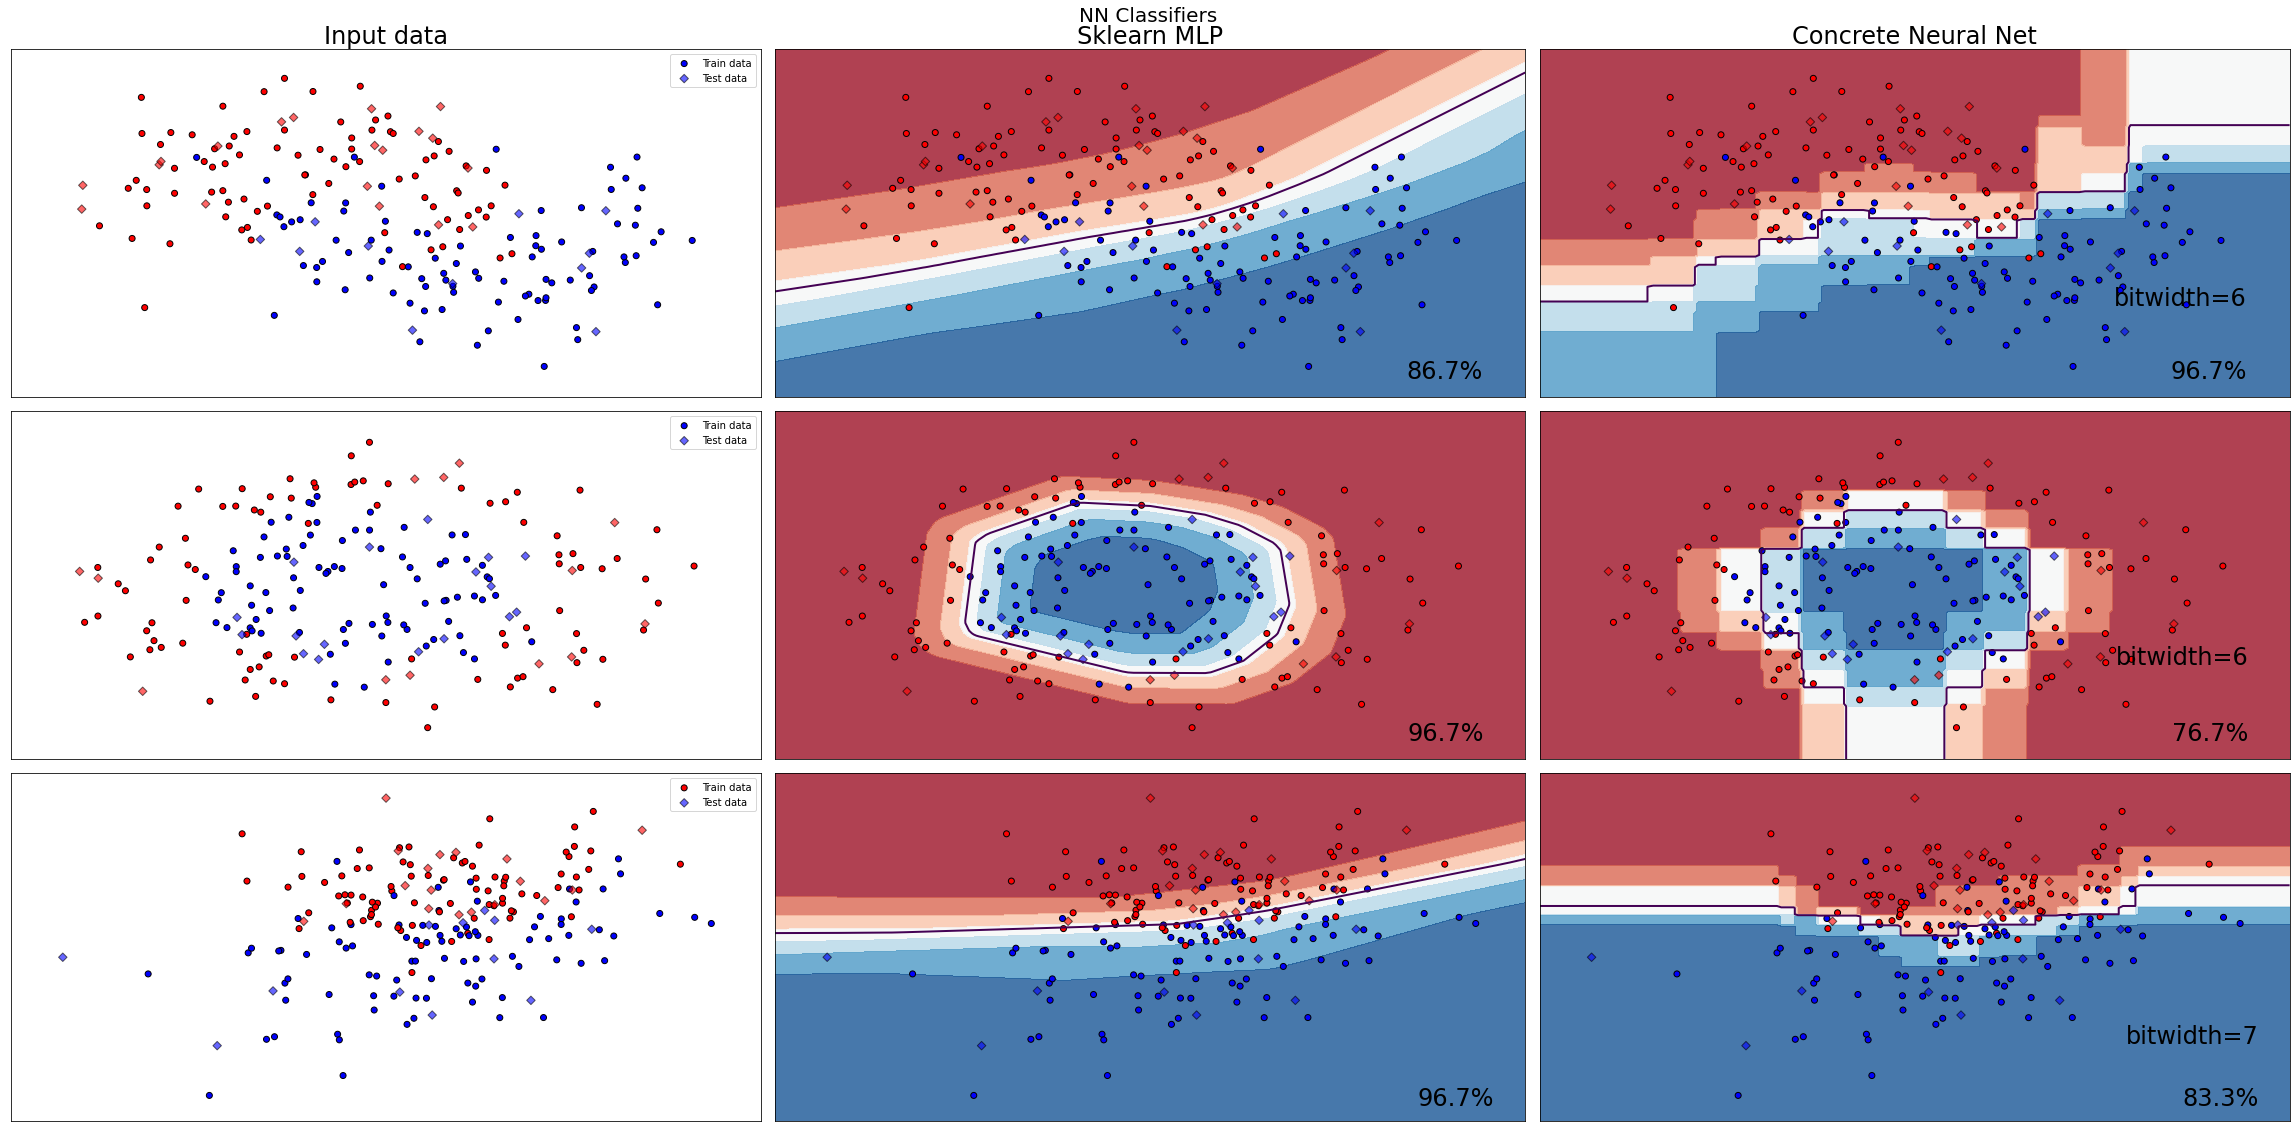

In [8]:
params_neural_net = {
    "module__n_outputs": 2,
    "module__input_dim": 2,
    "module__n_w_bits": 2,
    "module__n_a_bits": 4,
    "module__n_accum_bits": 32,
    "module__n_hidden_neurons_multiplier": 10,
    "module__n_layers": 2,  # 1 hidden layer
    "module__activation_function": torch.nn.ReLU,
    "max_epochs": 400,
    "verbose": 0,
    "lr": 0.001,
}

nn_classifier_list = [
    (partial(MLPClassifier, alpha=1, max_iter=1000, hidden_layer_sizes=(20,)), "Sklearn MLP"),
    (
        partial(ConcreteNeuralNetClassifier, batch_size=32, **params_neural_net),
        "Concrete Neural Net",
    ),
]

make_classifier_comparison("NN Classifiers", nn_classifier_list)

### Linear classifiers

In [ ]:
linear_classifier_list = [
    # Clear classifiers
    (partial(SVC, kernel="linear", C=0.025), "Linear SVC"),
    (LogisticRegression, "Logistic Regression"),
    # FHE classifiers
    (
        partial(
            ConcreteLinearSVC,
            n_bits={"net_inputs": 5, "op_inputs": 5, "op_weights": 2, "net_outputs": 8},
            C=0.025,
        ),
        "Concrete Linear SVC",
    ),
    (
        partial(
            ConcreteLogisticRegression,
            n_bits={"net_inputs": 5, "op_inputs": 5, "op_weights": 2, "net_outputs": 8},
        ),
        "Concrete Logistic Regression",
    ),
]

make_classifier_comparison("Linear Classifiers", linear_classifier_list)

### Tree and tree ensemble classifiers

In [ ]:
tree_classifier_list = [
    (partial(DecisionTreeClassifier, max_depth=5), "Decision Tree"),
    (partial(ConcreteDecisionTreeClassifier, max_depth=5), "Concrete Decision Tree"),
    (
        partial(RandomForestClassifier, max_depth=5, n_estimators=10, max_features=1),
        "Random Forest",
    ),
    (ConcreteRandomForestClassifier, "Concrete Random Forest"),
    (
        partial(XGBClassifier, n_jobs=1, n_estimators=20, max_depth=3, eval_metric="logloss"),
        "Sklearn XGB",
    ),
    (partial(ConcreteXGBClassifier, n_jobs=1), "Concrete XGB"),
]

make_classifier_comparison("Tree-Based Classifiers", tree_classifier_list)

## Conclusion

In this example we showed the results of three types of classifiers: 

* linear (Support Vector Machine, Logistic Regression)
* neural-networks (multi-layer non-linear models)
* tree-based (Decision Tree, Random Forest, XGBoost)

The accuracy of the **Concrete** classifiers is measured on encrypted data. These classifiers 
work with parameters and inputs that are heavily quantized and, thus, show accuracy loss:

* linear models: for this simple 2D case, linear models have good performance in FHE, similar to 
the performance of their fp32 counterparts
* neural networks: since several layers increase the number of computations in these classifiers, 
the effect of precision loss is compounded. These classifiers have poor performance in FHE
* tree-based classifiers: these classifiers achieve good accuracy both in fp32 and in quantized 
mode in FHE on encrypted data. Due to the particular computations in tree-based models, performance 
in FHE is maintained at the fp32 levels even on datasets which have a much higher number of 
dimensions

## Future work

In future releases of **Concrete-ML** we will improve the performance of linear classifiers on data
with more dimensions and we will improve neural networks to handle heavy quantization while 
minimizing the loss of accuracy.